In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sb
from matplotlib_venn import venn3

In [5]:

def load_predictions(filename):
    """
    Carga las predicciones desde un archivo CSV y realiza algunas operaciones de procesamiento.

    Parameters:
    filename (str): El nombre del archivo CSV con las predicciones.

    Returns:
    pd.DataFrame: DataFrame con las predicciones procesadas.
    """
    # Cargar las predicciones desde el archivo CSV
    predictions = pd.read_csv(filename)

    # Calcular la clase predicha y la etiqueta de espionaje para las predicciones
    predictions['predicted_class'] = predictions.iloc[:, 2:7].idxmax(axis=1).astype(int)
    predictions['ispion'] = predictions['class'].apply(lambda c: 1 if c == 4 else 0)
    predictions['ispionpred'] = predictions['predicted_class'].apply(lambda c: 1 if c == 4 else 0)

    # Generar la tercera columna 'resultado'
    predictions['result'] = ''

    # Calcular los valores de TP, FP, TN y FN
    predictions.loc[(predictions['ispion'] == 1) & (predictions['ispionpred'] == 1), 'result'] = 'TP'
    predictions.loc[(predictions['ispion'] == 0) & (predictions['ispionpred'] == 1), 'result'] = 'FP'
    predictions.loc[(predictions['ispion'] == 0) & (predictions['ispionpred'] == 0), 'result'] = 'TN'
    predictions.loc[(predictions['ispion'] == 1) & (predictions['ispionpred'] == 0), 'result'] = 'FN'

    # Asignar el valor 1 a la columna 'detected' por defecto
    predictions['detected'] = 1

    # Asignar el valor 0 a 'detected' donde la condición no se cumple
    mask = predictions[['0', '1', '2', '3', '4']].eq(predictions['0'], axis=0).all(axis=1)
    predictions.loc[mask, 'detected'] = 0

    return predictions

def filter_non_null_predictions(df):
    """
    Filtra las filas en el DataFrame donde todas las predicciones son nulas.

    Parameters:
    df (pd.DataFrame): DataFrame con las predicciones.

    Returns:
    pd.DataFrame: DataFrame filtrado sin predicciones nulas.
    """
    return df[~df[['0', '1', '2', '3', '4']].eq(df['0'], axis=0).all(axis=1)]

# Cargar predicciones desde archivos CSV
predictions_mrcnn = load_predictions('predicciones_mrcnn_postprocess_iou05.csv')
predictions_m2f = load_predictions('predicciones_m2f_tuned_post_process_05iou.csv')

# Filtrar predicciones no nulas
predictions_m2f_nonulls = filter_non_null_predictions(predictions_m2f)
predictions_mrcnn_nonulls = filter_non_null_predictions(predictions_mrcnn)


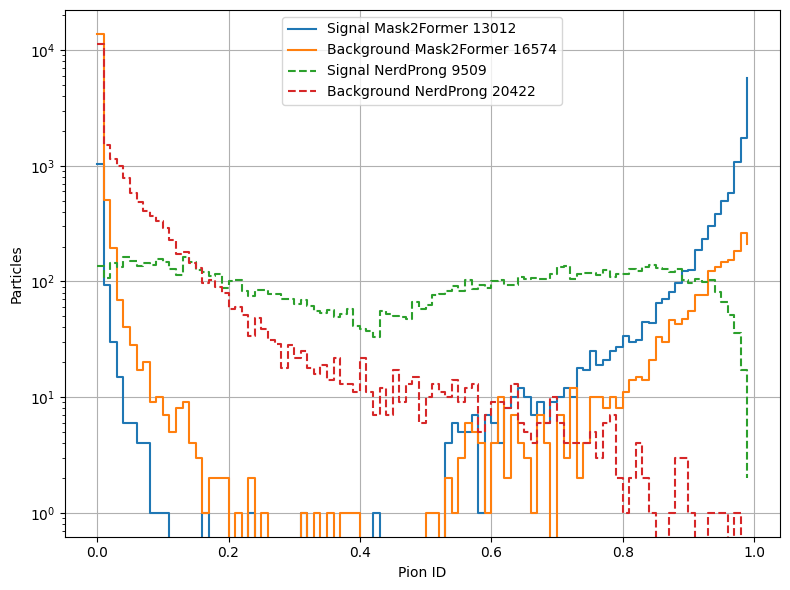

In [6]:


def suma_derecha(array):
    """
    Calcula la suma acumulativa de derecha a izquierda de un array.

    Parameters:
    array (numpy.ndarray): El array para calcular la suma.

    Returns:
    numpy.ndarray: La suma acumulativa de derecha a izquierda.
    """
    return np.cumsum(array[::-1])[::-1]

def plot_histogram(data, bins, linestyle, label):
    """
    Genera un histograma y lo representa gráficamente.

    Parameters:
    data (numpy.ndarray): Los datos para construir el histograma.
    bins (int): El número de bins para el histograma.
    linestyle (str): El estilo de línea para la representación gráfica.
    label (str): Etiqueta para la leyenda.

    Returns:
    None
    """
    hist, bins = np.histogram(data, bins=bins, range=[0, 1])
    plt.step(bins[:-1], hist, where='post', linestyle=linestyle, label=label)

def signal_vs_background(predictions, names, linestyles=['solid', 'dashed']):
    """
    Genera un gráfico de signal vs background a partir de las predicciones.

    Parameters:
    predictions (list of pd.DataFrame): Lista de DataFrames con las predicciones.
    names (list of str): Lista de nombres para las leyendas en el gráfico.
    linestyles (list of str, optional): Lista de estilos de línea para las curvas. Por defecto, ['solid', 'dashed'].

    Returns:
    None
    """
    plt.figure(figsize=(8, 6))

    for pred, name, linestyle in zip(predictions, names, linestyles):
        plot_histogram(pred[pred['ispion'] == 1]['4'], 100, linestyle, 'Signal ' + name+' '+str(len(pred[pred['ispion'] == 1]['4'])))
        plot_histogram(pred[pred['ispion'] == 0]['4'], 100, linestyle, 'Background ' + name+' '+str(len(pred[pred['ispion'] == 0]['4'])))

    plt.yscale('log')
    plt.xlabel('Pion ID')
    plt.ylabel('Particles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('plots/signal_noise_ratio' + "-".join(names) + '.jpg')
    plt.show()

# Ejemplo de uso:
signal_vs_background([predictions_m2f_nonulls,predictions_mrcnn_nonulls ], ['Mask2Former','NerdProng'])


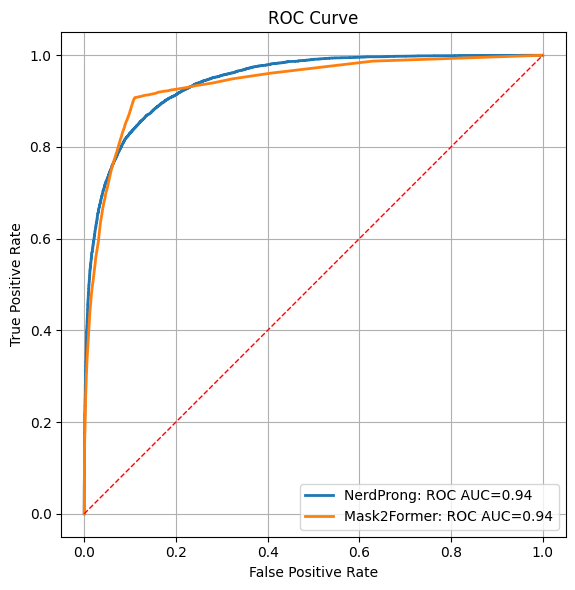

In [7]:

def plot_roc_curve(predictions, names):
    """
    Genera y muestra un gráfico de la curva ROC para las predicciones dadas.

    Parameters:
    predictions (list of pd.DataFrame): Lista de DataFrames con las predicciones.
    names (list of str): Lista de nombres para las leyendas en el gráfico.

    Returns:
    None
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    for pred, name in zip(predictions, names):
        lr_fpr, lr_tpr, _ = roc_curve(pred['ispion'].to_numpy(), pred['4'].to_numpy())
        lr_auc = roc_auc_score(pred['ispion'].to_numpy(), pred['4'].to_numpy())
        label = f"{name}: ROC AUC={lr_auc:.2f}"
        plt.plot(lr_fpr, lr_tpr, label=label, linewidth=2)

    plt.plot([0, 1], [0, 1], 'r--', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.savefig('plots/roc' + "-".join(names) + '.jpg')
    plt.show()


plot_roc_curve([predictions_mrcnn_nonulls, predictions_m2f_nonulls], ['NerdProng', 'Mask2Former'])


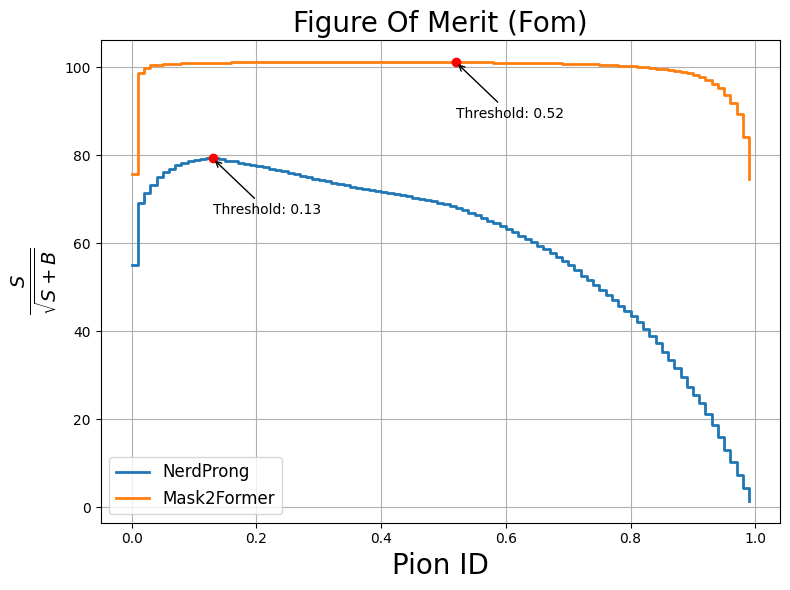

In [8]:


def suma_derecha(array):
    """
    Calcula la suma acumulativa de derecha a izquierda de un array.

    Parameters:
    array (numpy.ndarray): El array para calcular la suma.

    Returns:
    numpy.ndarray: La suma acumulativa de derecha a izquierda.
    """
    return np.cumsum(array[::-1])[::-1]

def plot_figure_of_merit(predictions, names):
    """
    Genera y muestra un gráfico del Figure of Merit (FOM) para las predicciones dadas.

    Parameters:
    predictions (list of pd.DataFrame): Lista de DataFrames con las predicciones.
    names (list of str): Lista de nombres para las leyendas en el gráfico.

    Returns:
    None
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    for pred, name in zip(predictions, names):
        signal_data = pred[pred['ispion'] == 1]['4']
        signal_hist, signal_bins = np.histogram(signal_data, bins=100, range=[0, 1])

        background_data = pred[pred['ispion'] == 0]['4']
        background_hist, background_bins = np.histogram(background_data, bins=100, range=[0, 1])

        signal_sum_right = suma_derecha(signal_hist)
        background_sum_right = suma_derecha(background_hist)

        fom_hist = signal_sum_right / np.sqrt(signal_sum_right + background_sum_right)
        fom_hist = np.nan_to_num(fom_hist, nan=0.0)

        ax.step(signal_bins[:-1], fom_hist, where='post', label=name, linewidth=2)

        max_value = np.round(np.max(fom_hist))
        max_index = np.argmax(fom_hist)

        ax.plot(signal_bins[max_index], fom_hist[max_index], 'ro')

        ax.annotate(f'Threshold: {signal_bins[max_index]}', xy=(signal_bins[max_index], fom_hist[max_index]),
                    xytext=(0, -40), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='black'))

    ax.legend(loc='lower left', fontsize='large')
    ax.set_xlabel('Pion ID', fontsize=20)
    ax.set_ylabel(r'$\frac{S}{\sqrt{S+B}}$', fontsize=20)
    ax.set_title('Figure Of Merit (Fom)', fontsize=20)

    plt.grid(True)
    plt.tight_layout()
    plt.savefig('plots/figure_of_merit' + "-".join(names) + '.jpg')
    plt.show()

plot_figure_of_merit([predictions_mrcnn_nonulls, predictions_m2f_nonulls], ['NerdProng', 'Mask2Former'])


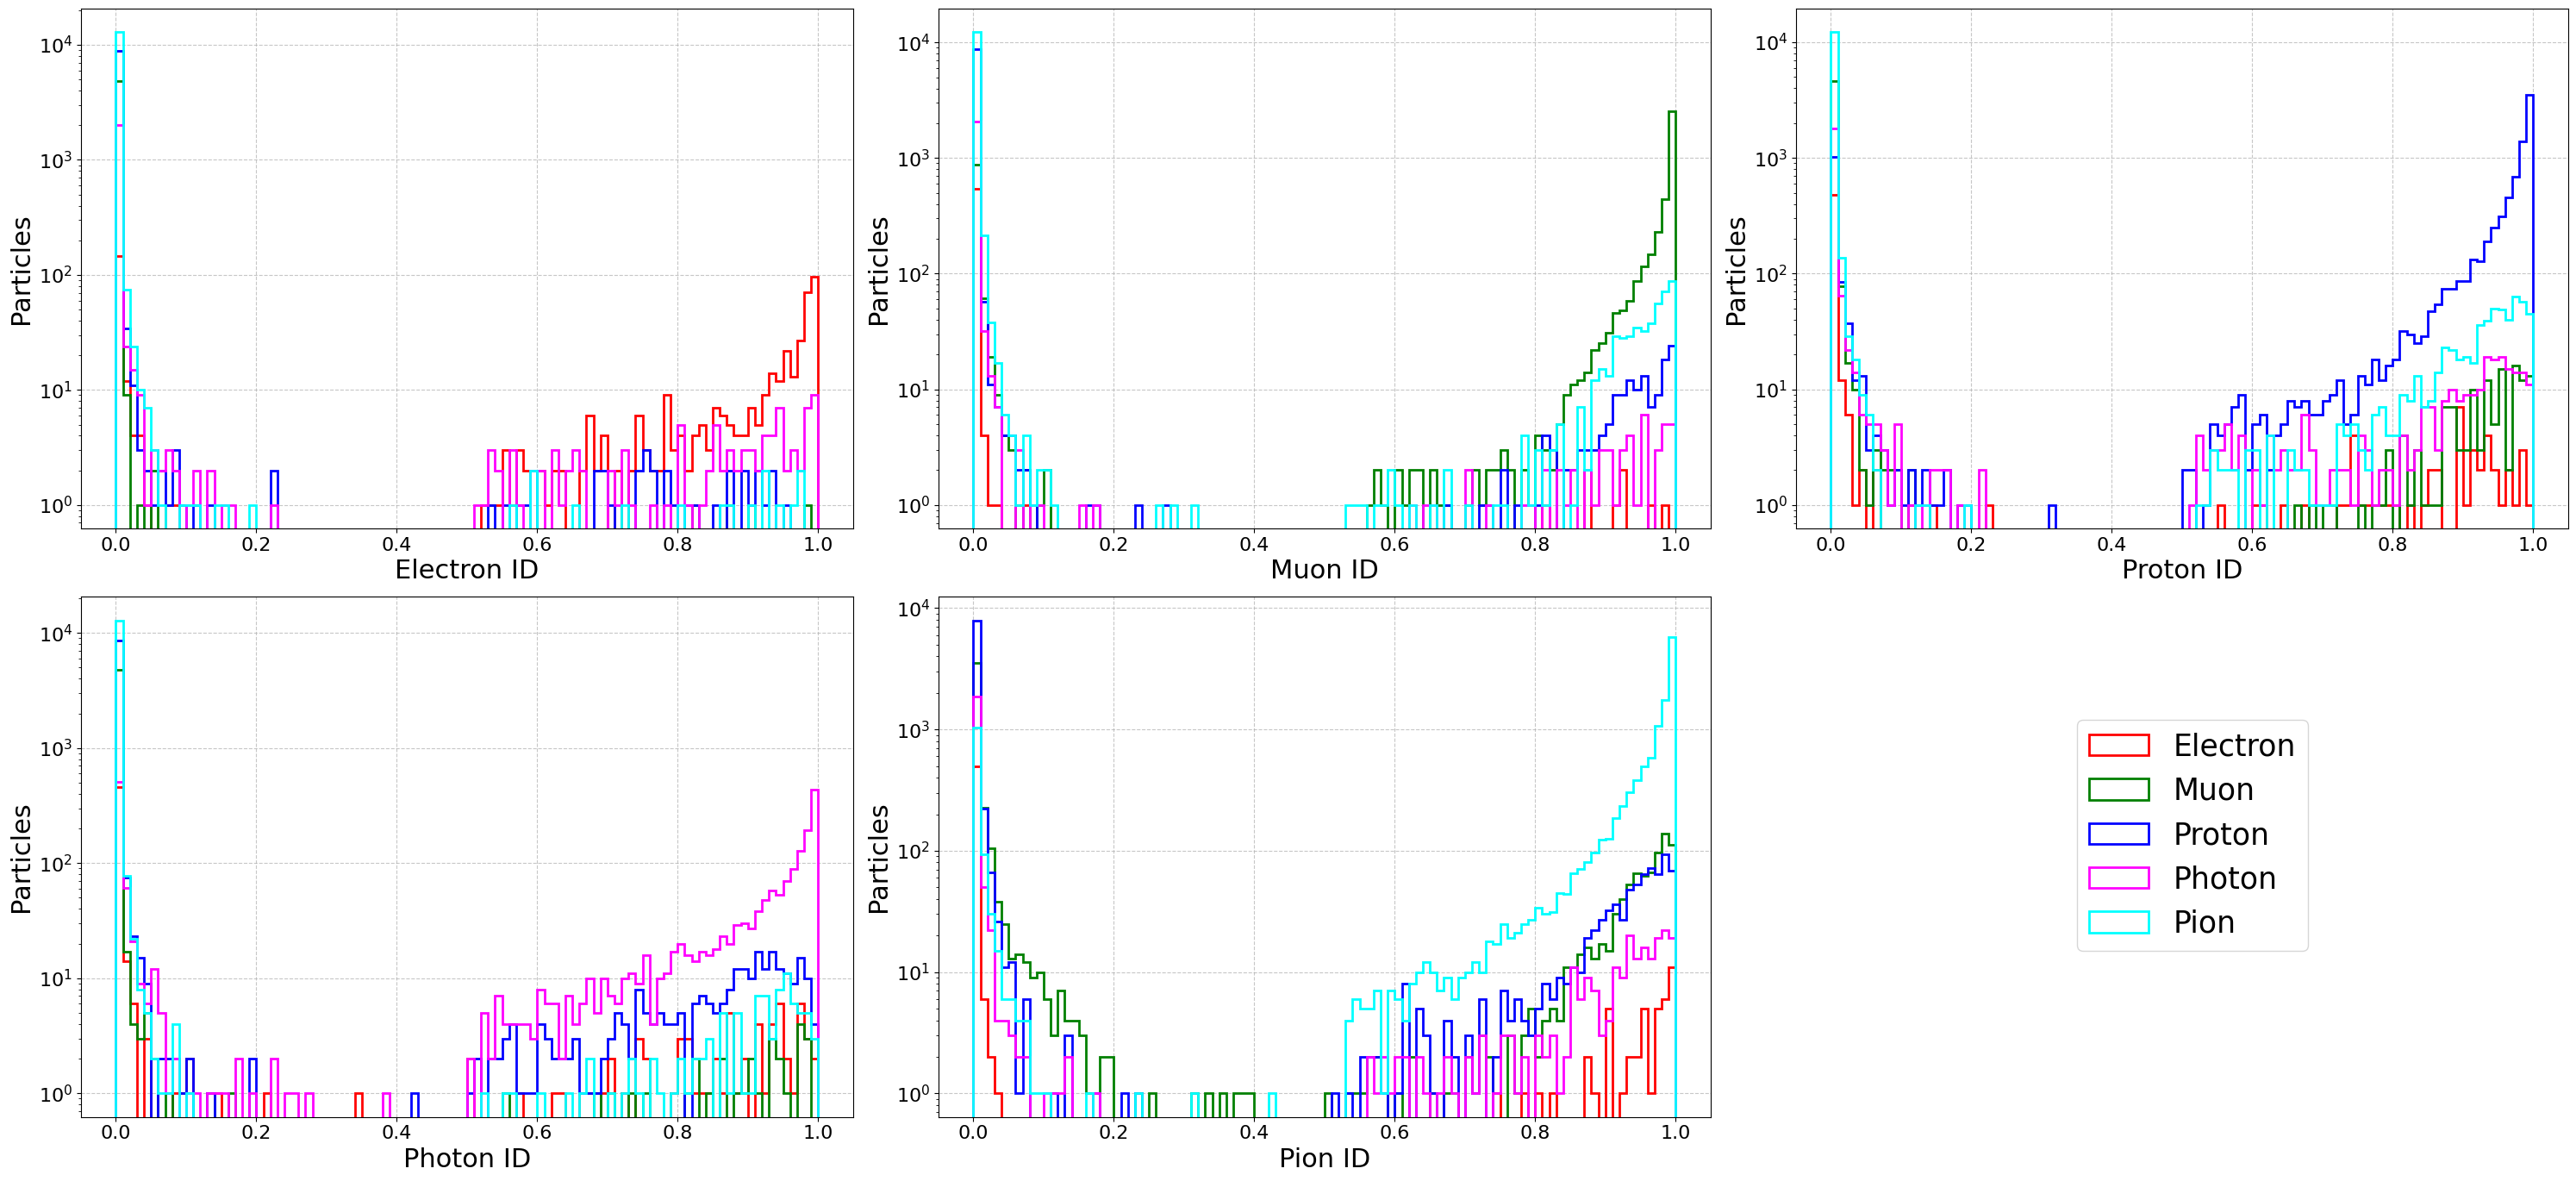

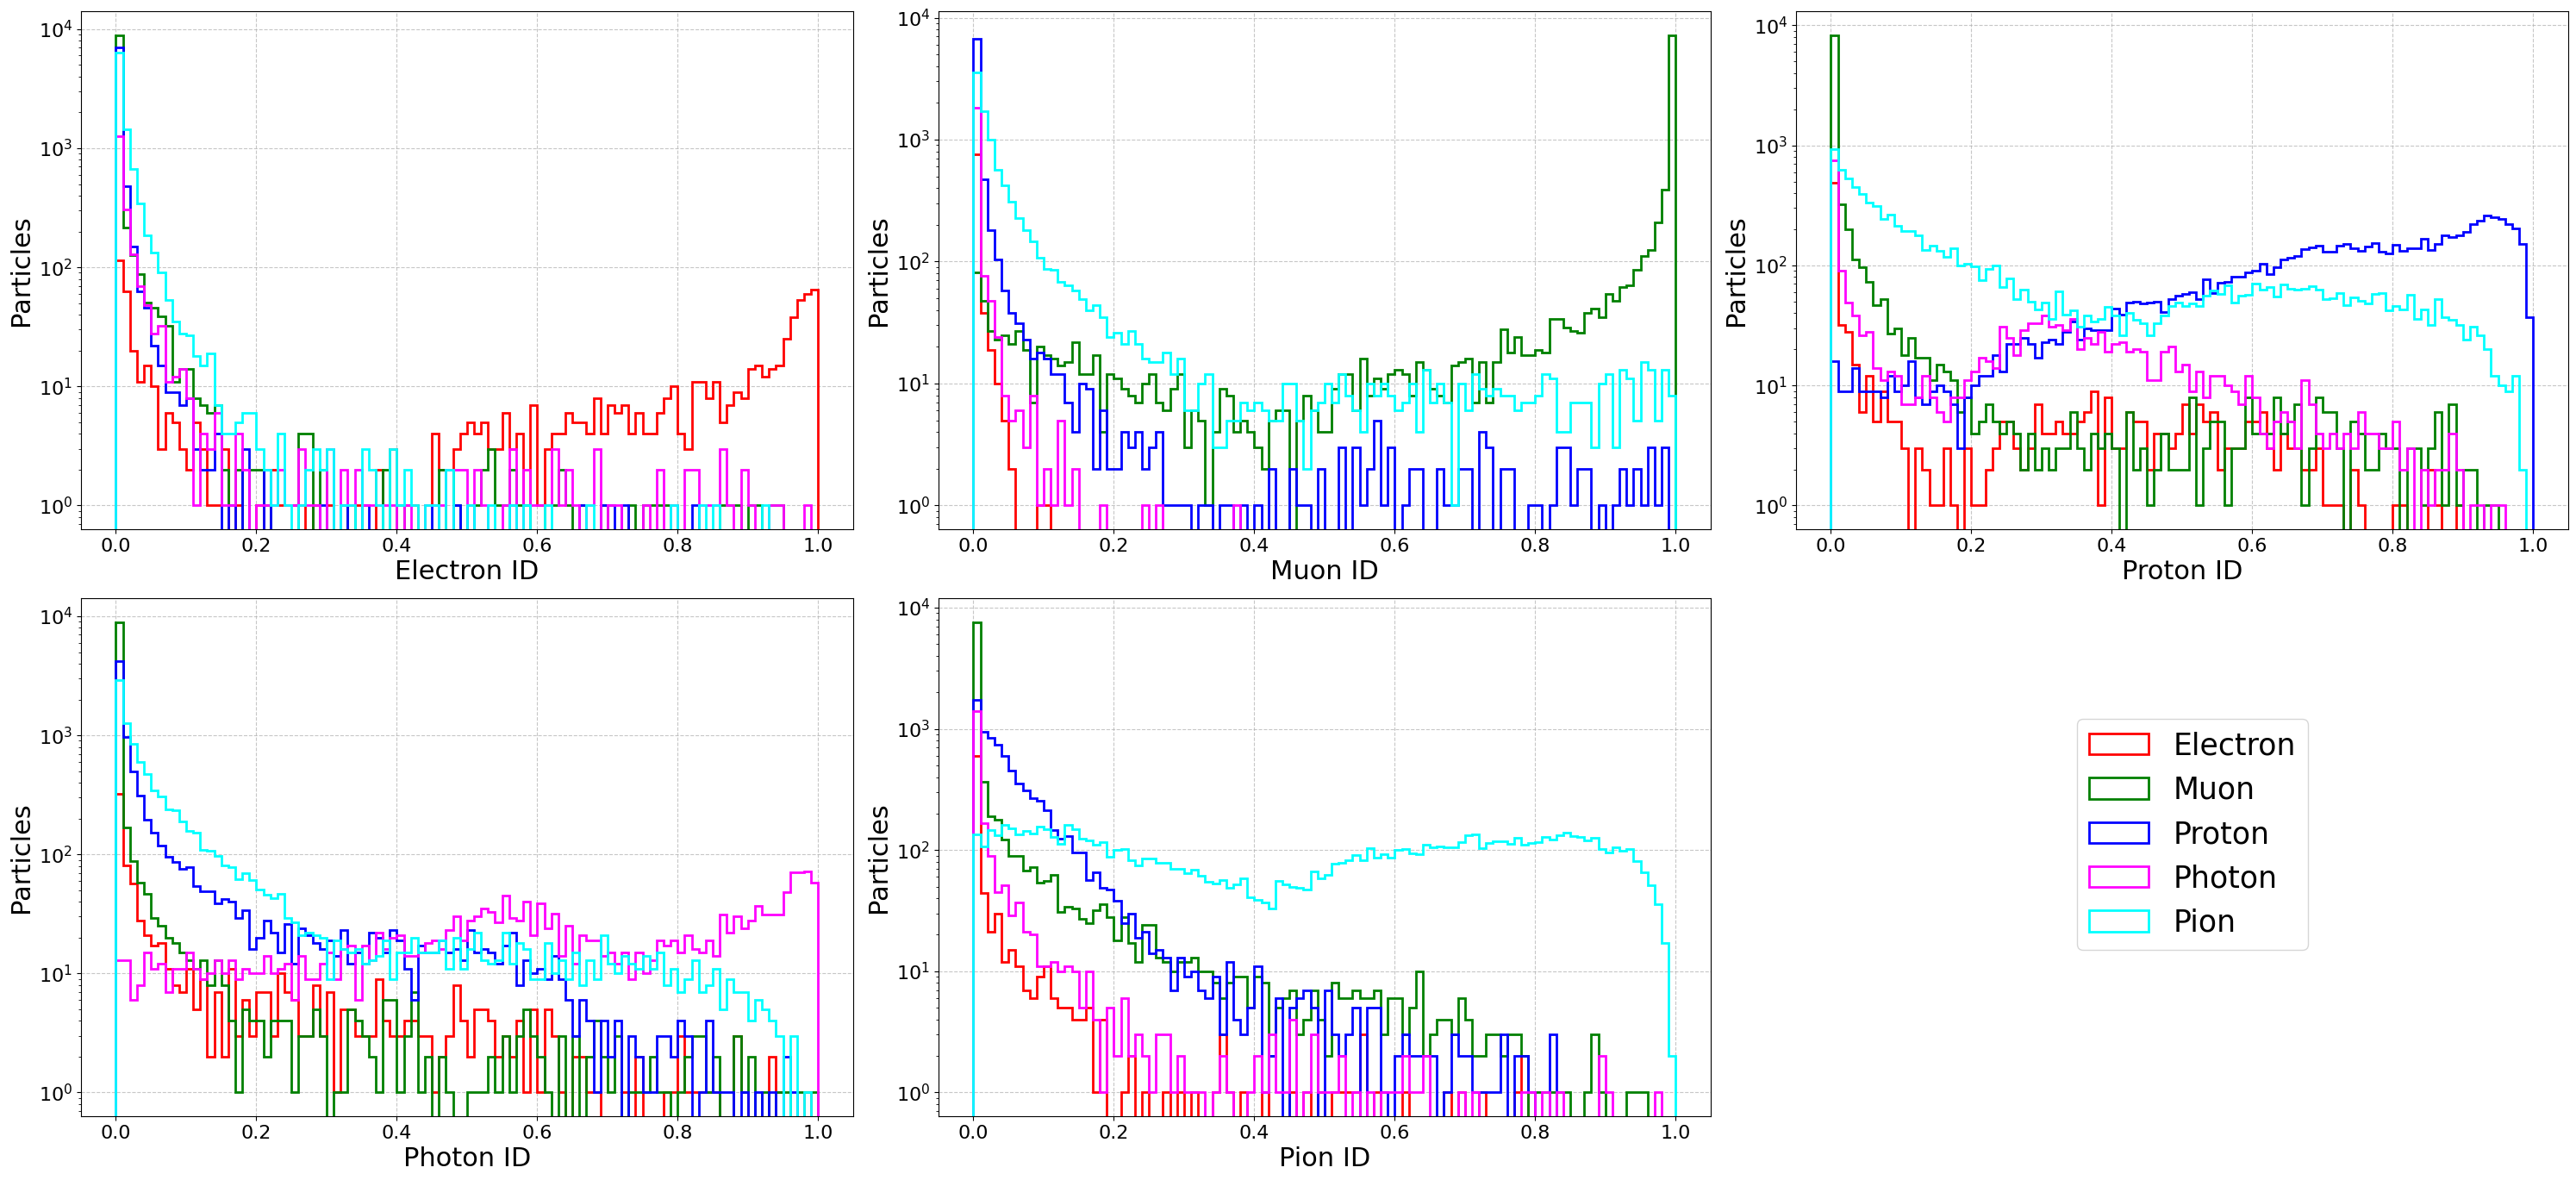

In [9]:

def plot_class_histograms(predictions):
    """
    Genera y muestra un gráfico de histogramas para cada clase en las predicciones dadas.

    Parameters:
    predictions (pd.DataFrame): DataFrame con las predicciones.

    Returns:
    None
    """
    plt.rcParams['figure.figsize'] = 30, 15
    fig, axes = plt.subplots(nrows=2, ncols=3)

    classes = ['0', '1', '2', '3', '4']
    colors = ["red", "green", "blue", "magenta", "cyan"]
    class_names = ['Electron', 'Muon', 'Proton', 'Photon', 'Pion']

    axes = axes.flatten()
    legend_artists = []

    for i, (class_label, ax) in enumerate(zip(classes, axes)):
        for label, color in zip(classes, colors):
            data = predictions[predictions['class'] == int(label)][class_label]
            artist = ax.hist(data, 100, histtype='step', stacked=True, fill=False,
                             color=color, label=label, range=[0, 1], density=False, linewidth=2)
            if i == 0:
                legend_artists.append(artist[-1][0])

        ax.set_ylabel('Particles', size=22)
        ax.set_yscale('log')
        ax.tick_params(axis='y', labelsize=16)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlabel(class_names[int(class_label)] + ' ID', fontsize=22)
        ax.tick_params(axis='x', labelsize=16)

    if len(classes) < 6:
        for ax in axes[len(classes):]:
            ax.axis('off')

    fig.legend(legend_artists, class_names, loc='lower right', fontsize=25, bbox_to_anchor=(0.9, 0.2))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('plots/class_histograms.jpg')
    plt.show()

# Ejemplo de uso:
plot_class_histograms(predictions_m2f_nonulls)
plot_class_histograms(predictions_mrcnn_nonulls)


[[  384     8    50    66    46]
 [    4  3875   129    29   809]
 [   35   147  7793   266   751]
 [  102    52   261  1541   226]
 [   15   482   609    95 11811]]
[[  384     8    50    66    46]
 [    4  3875   129    29   809]
 [   35   147  7793   266   751]
 [  102    52   261  1541   226]
 [   15   482   609    95 11811]]


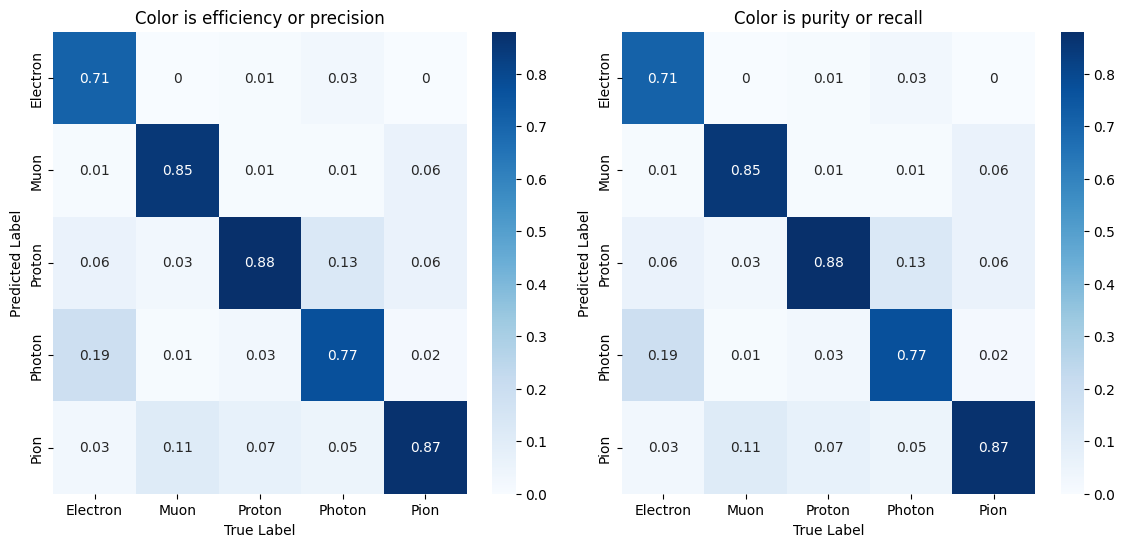

              precision    recall  f1-score   support

    Electron       0.71      0.69      0.70       554
        Muon       0.85      0.80      0.82      4846
      Proton       0.88      0.87      0.87      8992
      Photon       0.77      0.71      0.74      2182
        Pion       0.87      0.91      0.89     13012

    accuracy                           0.86     29586
   macro avg       0.82      0.79      0.80     29586
weighted avg       0.86      0.86      0.86     29586

[[14742  1832]
 [ 1201 11811]]


ValueError: Shape of passed values is (5, 5), indices imply (2, 2)

In [19]:


def calculate_normalized_matrix(matrix_original, axis=0):
    """
    Calculate the normalized matrix based on the given axis.

    Parameters:
        matrix_original (numpy.ndarray): The original matrix.
        axis (int): Axis along which normalization is performed (0 for column-wise, 1 for row-wise).

    Returns:
        numpy.ndarray: The normalized matrix.
    """
    print(matrix_original)
    sum_axis = np.sum(matrix_original, axis=axis)
    #return np.round(matrix_original / sum_axis[:, None if axis == 0 else np.newaxis], 4)
    
def plot_confusion_matrix(matrix_confusion, classes):
    """
    Plot the confusion matrix.

    Parameters:
        matrix_confusion (numpy.ndarray): The confusion matrix.
        classes (list): List of class labels.
    """
    dfmat_efficiency = pd.DataFrame(calculate_normalized_matrix(matrix_confusion, axis=0), index=classes, columns=classes)
    dfmat_purity = pd.DataFrame(calculate_normalized_matrix(matrix_confusion, axis=1), index=classes, columns=classes)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'wspace': 0.1})

    heatmap_efficiency = sb.heatmap(dfmat_efficiency, cmap='Blues', annot=True, fmt='g', ax=axes[0])
    heatmap_efficiency.set(xlabel='True Label', ylabel='Predicted Label')
    heatmap_efficiency.set_title('Color is efficiency or precision')

    heatmap_purity = sb.heatmap(dfmat_purity, cmap='Blues', annot=True, fmt='g', ax=axes[1])
    heatmap_purity.set(xlabel='True Label', ylabel='Predicted Label')
    heatmap_purity.set_title('Color is purity or recall')

    plt.savefig('plots/confusion_matrix.jpg')
    plt.show()

def confusion_matrix_analysis(predictions, target_class, predicted_class, class_names=None):
    """
    Perform and analyze confusion matrix for a specific target and predicted class.

    Parameters:
        predictions (pd.DataFrame): DataFrame with predictions.
        target_class (str): Actual class column name.
        predicted_class (str): Predicted class column name.
        class_names (list): List of class names. If None, class labels are extracted from unique values in the target column.

    Returns:
        None
    """
    y_real = predictions[target_class].to_list()
    y_pred = predictions[predicted_class].to_list()

    confusion_mat = confusion_matrix(y_real, y_pred)
    

    if class_names is None:
        class_labels = [str(label) for label in sorted(predictions[target_class].unique())]
    else:
        class_labels = class_names

    plot_confusion_matrix(confusion_mat, class_labels)

    print(classification_report(y_real, y_pred, target_names=class_labels))

# Example usage:
class_names = ['Electron', 'Muon', 'Proton', 'Photon', 'Pion']
confusion_matrix_analysis(predictions_m2f_nonulls, 'class', 'predicted_class', class_names)
confusion_matrix_analysis(predictions_m2f_nonulls, 'ispion', 'ispionpred', ['Other','Pion'])

confusion_matrix_analysis(predictions_mrcnn_nonulls, 'class', 'predicted_class', class_names)
confusion_matrix_analysis(predictions_mrcnn_nonulls, 'ispion', 'ispionpred', ['Other','Pion'])


17310


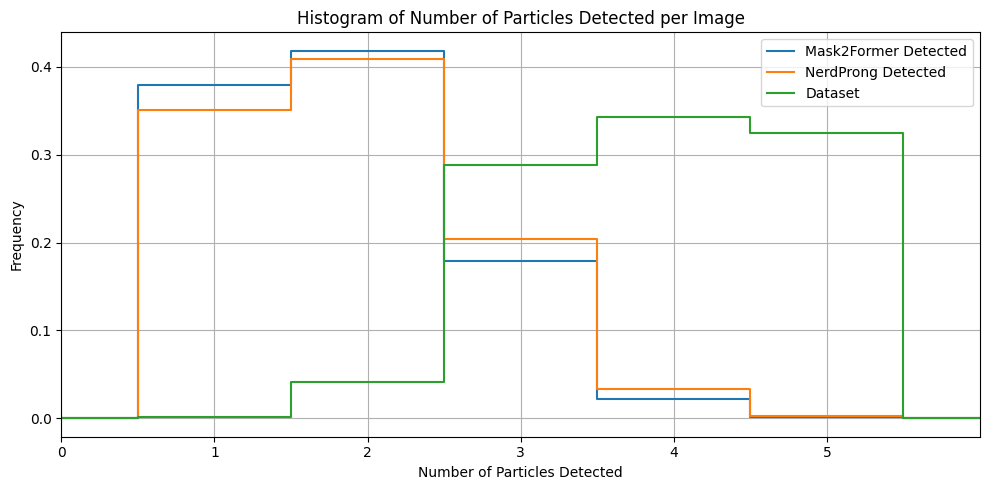

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def num_particles_distribution(dataframes, nombres):
    """
    Plot a histogram of the number of particles detected per image.

    Parameters:
        dataframes (list): List of DataFrames containing particle detection information.
        nombres (list): List of names for each DataFrame.

    Returns:
        None
    """
    plt.rcParams['figure.figsize'] = 10, 5
    fig, ax = plt.subplots()

    for pred, nom in zip(dataframes, nombres):
        detected_counts = pred.groupby('image_id')['detected'].sum()

        hist, bins = np.histogram(detected_counts, bins=[0, 1, 2, 3, 4, 5, 6, 7], density=True)
        ax.step(bins[:-1], hist, where='mid', label=f'{nom} Detected')

    # Add the dataset histogram
    dataset_counts = {6: 0, 4: 5936, 5: 5616, 3: 5000, 2: 724, 1: 34, 0: 0}
    dataset_counts = dict(sorted(dataset_counts.items()))
    print(sum(list(dataset_counts.values())))
    val_percentage = np.array(list(dataset_counts.values())) / sum(list(dataset_counts.values()))
    ax.step(list(dataset_counts.keys()), val_percentage, where='mid', label='Dataset')

    plt.xlabel('Number of Particles Detected')
    plt.ylabel('Frequency')
    plt.title('Histogram of Number of Particles Detected per Image')
    plt.legend()
    plt.xticks(range(0, 6))
    plt.xlim([0, 6])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


num_particles_distribution([predictions_m2f_nonulls, predictions_mrcnn_nonulls], ['Mask2Former', 'NerdProng'])


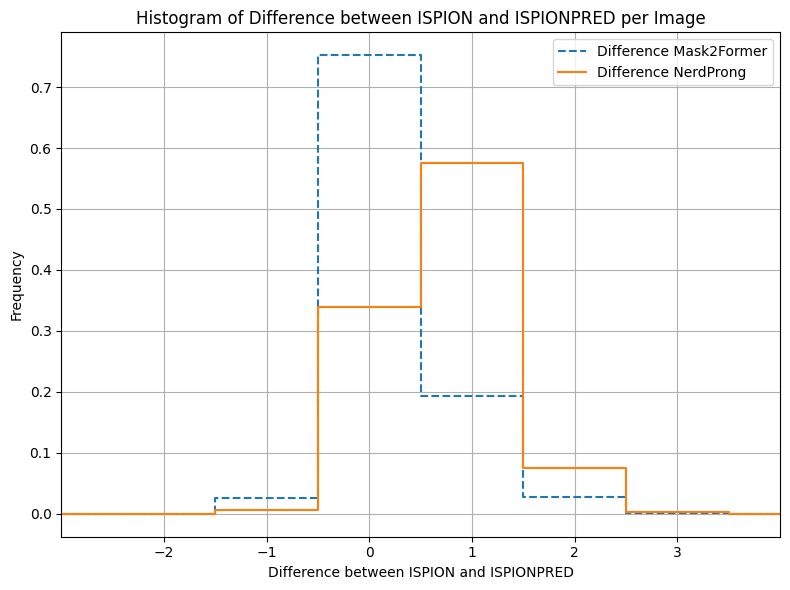

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_difference_histogram(ax, data, label, linestyle):
    """
    Plot a histogram of the differences in ISPION and ISPIONPRED.

    Parameters:
        ax (matplotlib.axes._axes.Axes): The axes on which to plot the histogram.
        data (pd.Series): Series containing the difference values.
        label (str): Label for the histogram.
        linestyle (str): Linestyle for the histogram.

    Returns:
        None
    """
    hist, bins = np.histogram(data, bins=[-3, -2, -1, 0, 1, 2, 3, 4, 5], density=True)
    ax.step(bins[:-1], hist, where='mid', label=label, linestyle=linestyle)

def dif_num_pions(predicciones, nombres):
    """
    Plot histograms of the difference between ISPION and ISPIONPRED for multiple predictions.

    Parameters:
        predicciones (list): List of DataFrames containing prediction information.
        nombres (list): List of names for each set of predictions.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    for pred, nom, linestyle in zip(predicciones, nombres, ['dashed', 'solid']):
        grouped = pred.groupby('image_id')[['ispion', 'ispionpred']].sum()
        grouped['diferencia'] = grouped['ispion'] - grouped['ispionpred']

        plot_difference_histogram(ax, grouped['diferencia'], f'Difference {nom}', linestyle)

    plt.xlabel('Difference between ISPION and ISPIONPRED')
    plt.ylabel('Frequency')
    plt.title('Histogram of Difference between ISPION and ISPIONPRED per Image')
    plt.legend()
    plt.xticks(range(-2, 4))
    plt.xlim([-3, 4])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


dif_num_pions([predictions_m2f, predictions_mrcnn], ['Mask2Former', 'NerdProng'])


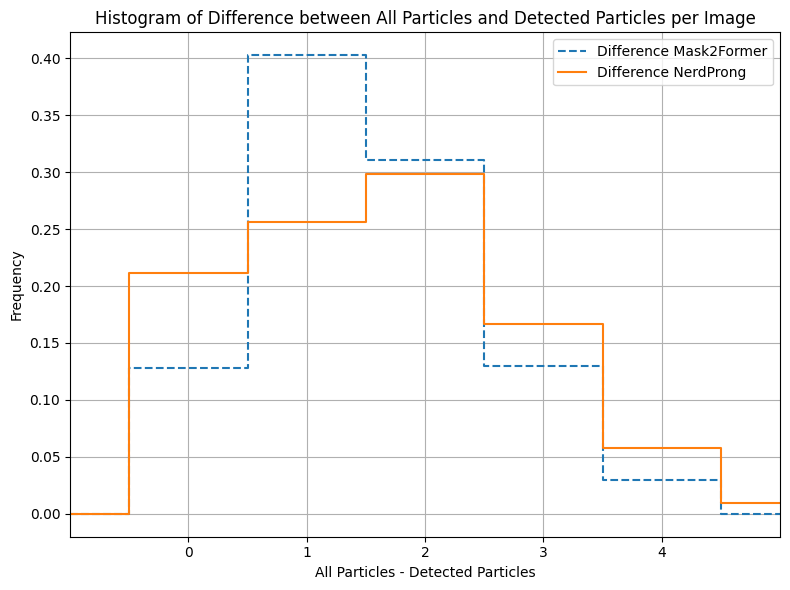

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_difference_histogram(ax, data, label, linestyle):
    """
    Plot a histogram of the differences in particle counts.

    Parameters:
        ax (matplotlib.axes._axes.Axes): The axes on which to plot the histogram.
        data (pd.Series): Series containing the difference values.
        label (str): Label for the histogram.
        linestyle (str): Linestyle for the histogram.

    Returns:
        None
    """
    hist, bins = np.histogram(data, bins=[-1, 0, 1, 2, 3, 4, 5, 6, 7], density=True)
    ax.step(bins[:-1], hist, where='mid', label=label, linestyle=linestyle)

def dif_num_particles(predicciones, nombres):
    """
    Plot histograms of the difference between all particles and detected particles for multiple predictions.

    Parameters:
        predicciones (list): List of DataFrames containing prediction information.
        nombres (list): List of names for each set of predictions.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    for pred, nom, linestyle in zip(predicciones, nombres, ['dashed', 'solid']):
        detectadas = pred.groupby('image_id')[['detected']].sum()
        totales = pred.groupby('image_id')[['detected']].count()
        diferencia = totales - detectadas

        plot_difference_histogram(ax, diferencia, f'Difference {nom}', linestyle)

    plt.xlabel('All Particles - Detected Particles')
    plt.ylabel('Frequency')
    plt.title('Histogram of Difference between All Particles and Detected Particles per Image')
    plt.legend()
    plt.xticks(range(0, 5))
    plt.xlim([-1, 5])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


dif_num_particles([predictions_m2f, predictions_mrcnn], ['Mask2Former', 'NerdProng'])


/tmp/ipykernel_2893811/137423944.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['id'] = df1.groupby('image_id').cumcount()
/tmp/ipykernel_2893811/137423944.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['id'] = df2.groupby('image_id').cumcount()


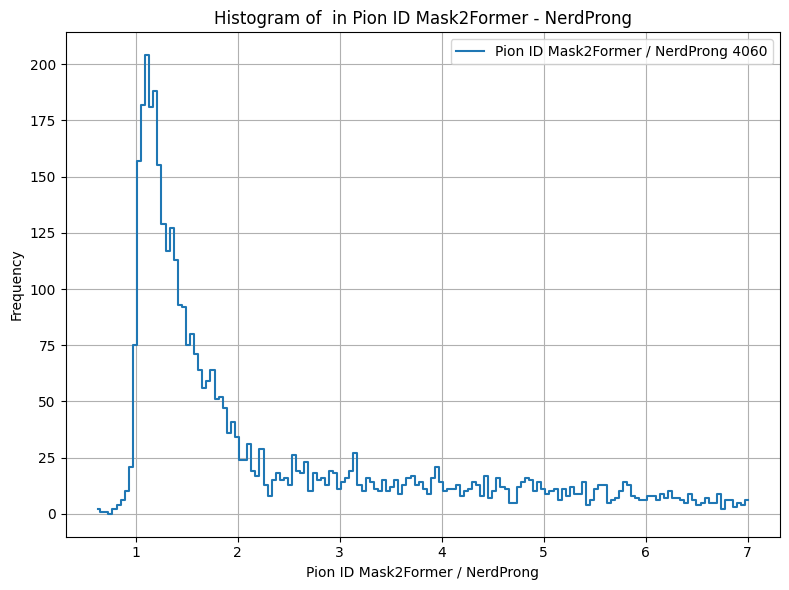

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_difference_histogram(ax, data, label, linestyle):
    """
    Plot a histogram of the differences in Pion ID.

    Parameters:
        ax (matplotlib.axes._axes.Axes): The axes on which to plot the histogram.
        data (pd.Series): Series containing the difference values.
        label (str): Label for the histogram.
        linestyle (str): Linestyle for the histogram.

    Returns:
        None
    """
    hist, bins = np.histogram(data, bins=160, density=False)
    ax.step(bins[:-1], hist, where='mid', label=label, linestyle=linestyle)

def dif_pion_id_por_particula(df1, df2):
    """
    Plot a histogram of the difference in Pion ID between two DataFrames.

    Parameters:
        df1 (pd.DataFrame): The first DataFrame containing Pion ID information.
        df2 (pd.DataFrame): The second DataFrame containing Pion ID information.

    Returns:
        None
    """
    df1['id'] = df1.groupby('image_id').cumcount()
    df2['id'] = df2.groupby('image_id').cumcount()
    #df1 = df1[df1['ispion'] == 1]
    df1 = df1[df1['4'] >0.4]
    #df2 = df2[df2['ispion'] == 1]
    df2 = df2[df2['4'] > 0.14]

    
    merged_df = pd.merge(df1, df2, on=['image_id', 'id'], suffixes=('_df1', '_df2'), how='inner')
    
    
    merged_df['difference'] = merged_df['4_df1'] / (merged_df['4_df2'])
    merged_df.loc[merged_df['4_df1']==0, 'difference']=-1
    merged_df.loc[merged_df['4_df2']==0, 'difference']=-2
    
    
    merged_df.to_csv('merged.csv')
    fig, ax = plt.subplots(figsize=(8, 6))
    
    
    plot_difference_histogram(ax, merged_df['difference'], 'Pion ID Mask2Former / NerdProng '+str(len(merged_df['difference'])), 'solid')
    
    merged_df=merged_df[merged_df['difference']>0  ]
    
    merged_df=merged_df[merged_df['difference']<2  ]
    
    #plt.yscale('log')
    plt.xlabel('Pion ID Mask2Former / NerdProng')
    plt.ylabel('Frequency')
    plt.title('Histogram of  in Pion ID Mask2Former - NerdProng')
    plt.legend()
    plt.grid(True)
    #plt.xlim([-2, 2]) 
    plt.tight_layout()
    plt.show()

dif_pion_id_por_particula(predictions_m2f_nonulls, predictions_mrcnn_nonulls)


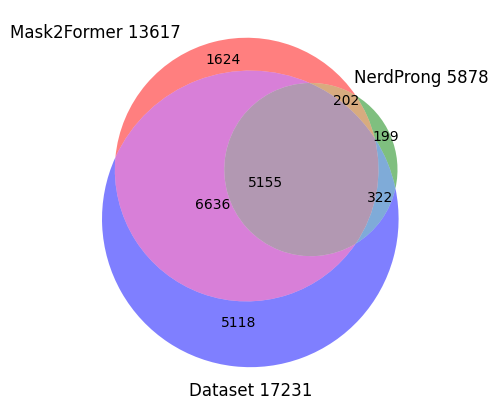

In [15]:


def venn_diagram_with_id_join(df1, df2):
    """
    Plot a Venn diagram based on the intersection of particles with ISPION and ISPION_PRED.

    Parameters:
        df1 (pd.DataFrame): The first DataFrame containing ISPION information.
        df2 (pd.DataFrame): The second DataFrame containing ISPION_PRED information.

    Returns:
        None
    """
    # Add a cumulative count ID for each particle within the same 'image_id'
    df1['id'] = df1.groupby('image_id').cumcount()
    df2['id'] = df2.groupby('image_id').cumcount()

    # Perform an inner join based on 'image_id', the new IDs, and 'ispion'
    merged_df = pd.merge(df1, df2, on=['image_id', 'id', 'ispion'], suffixes=('_df1', '_df2'), how='inner')

    # Create sets for the Venn diagram
    set_all = set(merged_df.index.tolist())
    set_ispion_1 = set(merged_df[merged_df['ispion'] == 1].index.tolist())
    set_ispionpred_1_df1 = set(merged_df[(merged_df['ispionpred_df1'] == 1)].index.tolist())
    set_ispionpred_1_df2 = set(merged_df[(merged_df['ispionpred_df2'] == 1)].index.tolist())

    # Plot the Venn diagram
    venn = venn3([set_ispionpred_1_df1, set_ispionpred_1_df2, set_ispion_1],
                 set_labels=('Mask2Former '+str(len(set_ispionpred_1_df1)),'NerdProng '+str(len(set_ispionpred_1_df2)),  'Dataset '+str(len(set_ispion_1))),
                 alpha=0.5)

    # Adjust font sizes for better readability
    for text in venn.set_labels:
        text.set_fontsize(12)

    for text in venn.subset_labels:
        if text:
            text.set_fontsize(10)

    plt.show()

venn_diagram_with_id_join(predictions_m2f, predictions_mrcnn) 

#15679